# **Advanced Lane Finder** 
***
The goals / steps of this project are the following:

    1.Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    2. Apply a distortion correction to raw images.
    3. Use color transforms, gradients, etc., to create a thresholded binary image.
    4. Apply a perspective transform to rectify binary image ("birds-eye view").
    5. Detect lane pixels and fit to find the lane boundary.
    6. Determine the curvature of the lane and vehicle position with respect to center.
    7. Warp the detected lane boundaries back onto the original image.
    8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [35]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import pickle
#%matplotlib inline
%matplotlib qt

**Camera Calibration part 1**

Use 20 sample chess board picutures under /camera_cal directory to calibrate camera. 

First step, load camlibration image, create object point and image point arrary and use cv2.findChessboardCorner cv2.drawChessboardCorners functiuon to find and draw chessborad coners

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

In [37]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners

for idx, fname in enumerate(images):     
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #print('image name: ', fname)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)  

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        #print('image name found corner: ', fname)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        write_name = 'camera_cal_output/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

**Camera Calibration part 2**

Ues object points and image points collected in part 1 as input to cv2.calibrateCamer to get camera calibration matrix and disort distance. And use one of the image to test it.  Finally save camera calibrate matrix in a file so that it can be loaded from file later



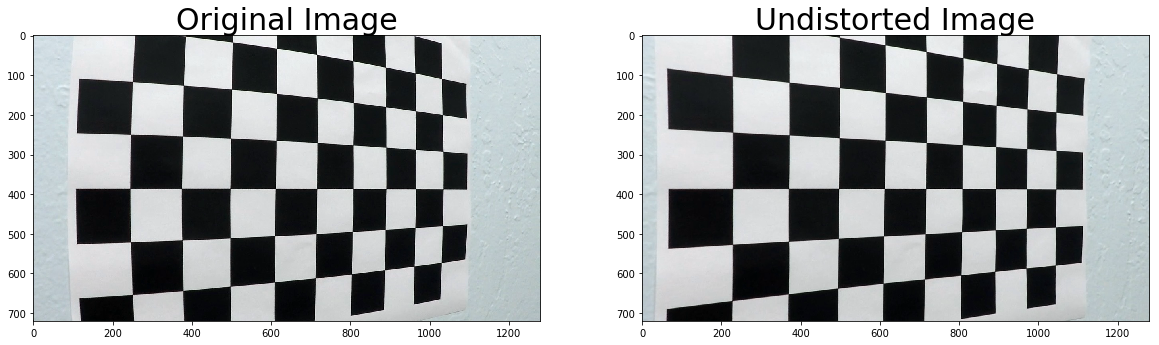

In [38]:


cali_file = "camera_cal_output/camera_dist_pickle.p"

# Test undistortion on an image
img = cv2.imread('camera_cal/test.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal_output/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( cali_file, "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

**Image process pipeline **

The input image will be process by following pipeline:
1. Undistort the iamge using calibrate matrix caculated in camera calibration section
2. Convert RGB color space to HLS color space
3. Get X Sobel gradient binary image on L channel using proper threshold
4. Get S channel binary image using proper threshold
5. Combine X Sobel gradent binary image and S channel threhold binary image

The conbined binary image will be used to detect lane lines



This image is:  <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
Original image: 


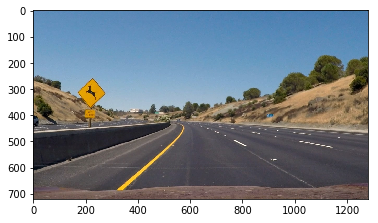

Undistorted image: 


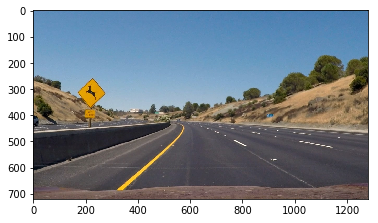

Sobel X Binary


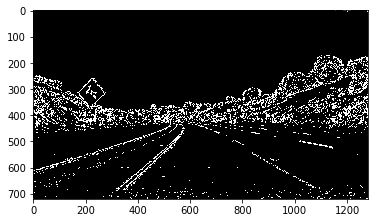

S Channel


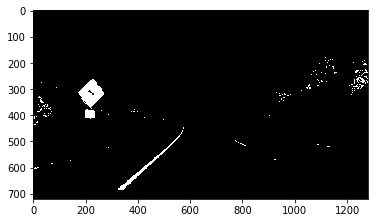

Combined Color


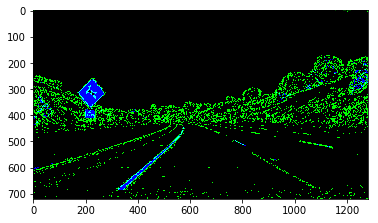

Combined Binary


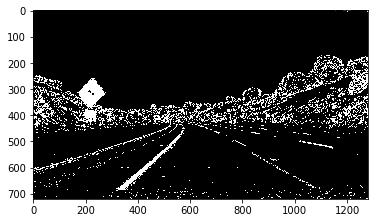

In [43]:
import math
%matplotlib inline

cali_file = "camera_cal_output/camera_dist_pickle.p"
output_dir = 'output_images/'


image_size = [1280, 720] ## Width X Height
#Threshold 
sobel_x_threshold=(15, 90)
hls_s_ch_threshold=(155, 255) 




#Load camera saved calibration matrix and from pickle file
with open(cali_file, mode='rb') as f:
    caliParams = pickle.load(f)
    
mtx, dist = caliParams['mtx'], caliParams['dist']

#Undistort image
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

#Convert coler image(BGR read by cv2.imraed) to gray scale
def grayscale_2(img):    
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Convert coler image(RGB read by mpimg.imread) to gray scale
def grayscale(img):    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


#Funtion to get sobel by given orientation 
def sobel(grayImg,  orient='x', sobel_kernel=3,):    
    so = None
    if orient == 'x':
        so = cv2.Sobel(grayImg, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        so = cv2.Sobel(grayImg, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    return so

# function that applies Sobel x or y,
#for a given orientaton and threshold

def abs_sobel_thresh(grayImg, orient='x', thresh=(0, 255), kernel_size=3):    
    #gray = grayscale(img)
    so = sobel(grayImg, orient = orient, sobel_kernel=kernel_size)    
    abs_sobel = np.absolute(so)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

# function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(grayImg, kernel_size=3, thresh=(0, 255)):
    # Convert to grayscale
    #gray = grayscale(img)
    # Take both Sobel x and y gradients
    sobelx = sobel(grayImg, orient='x', sobel_kernel=kernel_size)
    sobely = sobel(grayImg, orient='y', sobel_kernel=kernel_size)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return binary_output

# Define a function to return direction of the gradient
def dir_threshold(grayImg, kernel_size=3, thresh=(0, np.pi/2)):
    #gray = grayscale(img)
    # Take both Sobel x and y gradients
    sobelx = sobel(grayImg, orient='x', sobel_kernel=kernel_size)
    sobely = sobel(grayImg, orient='y', sobel_kernel=kernel_size)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

#Convert RGB image to HLS
def convert_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

#Get one of H, L, S channel from hls image
def hls_channel(hlsImg, channel='s'):
    one_channel = None
    if channel=='s':
        one_channel = hlsImg[:,:,2]
    elif channel=='l':
        one_channel = hlsImg[:,:,1]
    elif channel == 'h':
        one_channel = hlsImg[:,:,0]
    else:
        one_channel = None
    return one_channel    

# Define a function that thresholds the H, L, or S-channel
#of HLS by given channel
def hls_threshold(channel , thresh=(0, 255)):
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output






def showGrayImage(img, title):
    print (title)
    plt.imshow(img, cmap='gray')
    plt.show()
    
def showColorImage(img, title):
    print (title)
    plt.imshow(img)
    plt.show()    
    
#Get combined threshold binary image. Input should be a undistorted iamge
def pipeline(img, s_thresh=(170, 255),  sx_thresh=(20, 100),
             sy_thresh=(20, 100), kernel_size=3, showImage=False):
    org_img = np.copy(img) 
    # Convert RGB to HLS
    hls_img = convert_hls(img)
    # Get L channel image
    l_channel = hls_channel(hls_img, 'l')
    # Get X Sobel binary image on L channel
    sxbinary = abs_sobel_thresh(l_channel, orient='x', thresh=sx_thresh, kernel_size=kernel_size)
    
    if showImage is True:
        showGrayImage(sxbinary, 'Sobel X Binary')
    #Get S channel
    s_channel = hls_channel(hls_img , 's')    
    #Get S channel threshold binary image
    s_binary = hls_threshold(s_channel, thresh= s_thresh)
    if showImage is True:
        showGrayImage(s_binary, 'S Channel')    
    #Create Combined color image
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) *255
    if showImage is True:
        showColorImage(color_binary, 'Combined Color')
    combined_binary = np.zeros_like(sxbinary)
    #Create Combined binary image for lane detection
    combined_binary[(s_binary == 1) | (sxbinary == 1) ] = 1
    if showImage is True:
        showGrayImage(combined_binary, 'Combined Binary')
    return org_img, color_binary, combined_binary

test_file = "test_images/test2.jpg"
test_img = mpimg.imread(test_file)
print('This image is: ',type(test_img), 
         'with dimensions:', test_img.shape) 
    
showColorImage (test_img, 'Original image: ')
undist_test = undistort(test_img)
showColorImage (test_img, 'Undistorted image: ')

#Test pipeline
_, _, test_combined = pipeline(image, 
         s_thresh=hls_s_ch_threshold,                                  
         sx_thresh=sobel_x_threshold, 
         kernel_size=3,
         showImage=True
    )




**Perspective Transformation **

The combined binary image is transformed to bird eye view image so that two lane lines are parallel on image and remove noise. Source points and destination point are picked by lot of experiment.


Warped


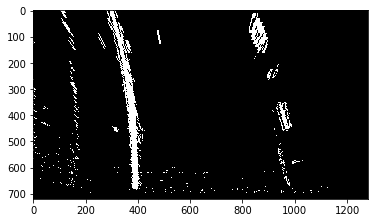

In [48]:
top_right_src = [725, 460]
top_left_src = [575, 460]
bottom_right_src = [1080, 680]
bottom_left_src = [250, 680]

top_right_dest = [980, 20]
top_left_dest = [320, 20]
bottom_right_dest = [980, 680]
bottom_left_dest = [320,680]

# src coordinates
src = np.float32([
    top_right_src, # top right
    bottom_right_src, # bottom right
    bottom_left_src, # bottom left
    top_left_src # top left
])

# dest coordinates
dst = np.float32([
    top_right_dest, # top right
    bottom_right_dest, # bottom right
    bottom_left_dest, # bottom left
    top_left_dest # top left
])

#Function to do perspective transformaton
def unwarp(img, src, dst, reverse=False):
    
    M = cv2.getPerspectiveTransform(src, dst)
    if reverse is True:
        M = cv2.getPerspectiveTransform(dst, src)   
        
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST)
    return warped

#Test warp image
test_warped = unwarp(test_combined, src, dst)
showGrayImage(test_warped, 'Warped')

**Lane Line Detection **

The combined binary image is transformed to bird eye view image so that two lane lines are parallel on image and remove noise. Source points and destination point are picked by lot of experiment 

Line finding method: peaks in histogram

On warped binary image, find pixel at peak of the histogram. Use those pixels at peak of histogram to fit a polynomial line.

If lane line is detected, lane finding for next frame in video can start with previous found line position without doing histogram calculation.

Perform following line detection sanity check to verify if it is a good detection
    Checking that they have similar curvature
    Checking that they are separated by approximately the right distance horizontally
    Checking that they are roughly parallel


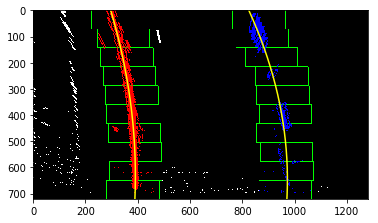

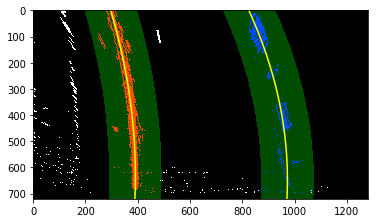

In [54]:
#Blind lane finder using histogram and sliding window techniques
def blind_lane_finder(binary_warped, margin=100, minpix = 50, showImage=False): 
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if showImage:            
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    if showImage:        
        plot_lane(binary_warped, out_img, left_fit, right_fit, left_lane_inds, right_lane_inds)
    return leftx, lefty, rightx, righty, left_fit, right_fit

##Fine lane based on lane position found in previous frame
def simple_lane_finder(binary_warped, pre_left_fit, pre_right_fit, margin=100, minpix = 50, showImage=False):
   
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (pre_left_fit[0]*(nonzeroy**2) + pre_left_fit[1]*nonzeroy + pre_left_fit[2] - margin))
                      & (nonzerox < (pre_left_fit[0]*(nonzeroy**2) + pre_left_fit[1]*nonzeroy + pre_left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (pre_right_fit[0]*(nonzeroy**2) + pre_right_fit[1]*nonzeroy + pre_right_fit[2] - margin))
                       & (nonzerox < (pre_right_fit[0]*(nonzeroy**2) + pre_right_fit[1]*nonzeroy + pre_right_fit[2] + margin)))  

    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return leftx, lefty, rightx, righty,left_fit, right_fit 


def plot_lane(binary_warped, out_img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, image_size[0])
    plt.ylim(image_size[1], 0)
    plt.show()
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, image_size[0])
    plt.ylim(image_size[1], 0)
    plt.show()
    

def get_x(line_fit, y_val):
    poly = np.poly1d(line_fit)
    x_val = poly(y_val)
    return x_val

#Calucate avage lane width
def get_lane_width(line_fit, y_val):
    poly = np.poly1d(line_fit)
    x_val = poly(line_y)
    return x_val
    
#Calculate curvature of lane lines, valication curvature of left and right lane
#Calculate distance from center
#Checck lane witdth and 
def is_good_dectetion(leftx, lefty, rightx, righty, left_fit, right_fit):
    result = True
    ##Caculate Curvature
    y_eval = image_size[1] -1
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    #Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimensio
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curv = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curv = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)/ np.absolute(2*right_fit_cr[0])
    max_curv=max(left_curv, right_curv)
    min_curv=min(left_curv, right_curv)
    ratio = max_curv/min_curv
    #print('left curvature: ', left_curv, ' right curvature', right_curv, ' ratio: ', ratio)
    ## Assume if there are 
    if ratio > 5:
        result = False
    #calcuate distance from center    
    center_in_m = image_size[0]  * xm_per_pix / 2
    bm_leftx_in_m = get_x(left_fit_cr, y_eval  * ym_per_pix)
    bm_rightx_in_m = get_x(right_fit_cr, y_eval  * ym_per_pix)
    dfc = np.absolute(center_in_m - np.mean([bm_leftx_in_m, bm_rightx_in_m]))
    
    #Choose four set of point on the lines
    y_vals = [1, image_size[1]  // 4, image_size[1] // 2, image_size[1]  // 4 * 3, image_size[1]-1 ]
    
    #Check lane width
    distances = []
    for y in y_vals:
        leftx_in_m = get_x(left_fit_cr, y  * ym_per_pix)
        rightx_in_m = get_x(right_fit_cr, y  * ym_per_pix) 
        distances.append(np.absolute(leftx_in_m - rightx_in_m))
    #print('distances: ', distances)
    avg_width = np.mean(distances)
    max_width = max(distances)
    min_width = min(distances)
    delta = np.absolute(avg_width - 3.7)  #3.7m is standard highway lane witdth in US  
    #print('max distance: ', max_width, 'min distance: ', min_width,  'avg distance: ', avg_width, ' delta: ', delta)
    if delta > 1:
        result = False        
    
    #Check lane parallel
    minmax_ratio = max_width/min_width
    #print('minmax ratio: ', minmax_ratio)
    if minmax_ratio > 1.4:
        result = False
       
    # return our radius of curvature is in meters
    return result, left_curv, right_curv, dfc

   

# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
 
_, _, _, _, _, _ = blind_lane_finder(test_warped, 
                                     margin=margin, 
                                     minpix=minpix, 
                                     showImage=True)     


## Draw lane on image

After lane line is detected, draw the lane line on warped image first, then reversely wrap the lane line to undistorted image and display the lane area on image.

Use Line class to track line detection status. And use average fit from recent good frames to smoothen the line. If a bad detection happened in some difficulty frame, use previous good detection to draw lines for that frame. However, bad detection happens for several frame continuously, start blind search again. In this project, 5 recent good frame are used to smooth lines. If more than 10 continuous bad frames, use blinder search to find line from beginning.


In [3]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #bad frame count
        self.bad_frame_count = 0
        #Max continueous bad frame nubmer
        self.max_bad_frame = 10
        #Max recent good fit used for smoothing lane line
        self.max_good_fit = 5
        


This image is:  <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
Original image: 


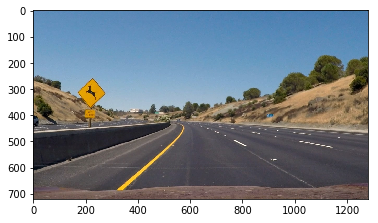

Output Image


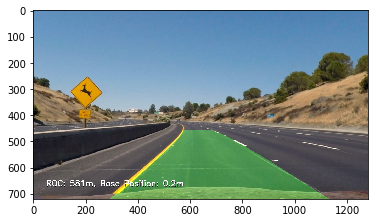

In [55]:
left_line = Line()
right_line = Line()



def draw_lane_on_image(undistImage, warpedImage, left_fit, right_fit, roc, dfc):
    warp_zero = np.zeros_like(warpedImage).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warpedImage.shape[0]-1, warpedImage.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    #showImage(color_warp, 'Color Warp' )

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    reversewarp = unwarp(color_warp, dst, src)
    #showImage(reversewarp, 'Reverse Warp Image' )
    # Combine the result with the original image
    result = cv2.addWeighted(undistImage, 1, reversewarp, 0.3, 0)
     # Print curvature and center offset on an image
    stats_text = 'ROC: {0:.0f}m, Base Position: {1:.1f}m'.format(roc, \
                                                                dfc)
    text_offset = 50
    text_shift = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, stats_text, \
                (text_offset + text_shift, warpedImage.shape[0] - text_offset + text_shift), \
                font, 1, (0, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(result, stats_text, (text_offset, warpedImage.shape[0]- text_offset), \
                font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return result





#Track and update left and right lane line instances when a good lane is detected
#in current frame
def handle_good_detection(leftx, lefty, rightx, righty,
                          left_fit, right_fit, left_curv,
                          right_curv, dfc):
    
    max_good_fit = left_line.max_good_fit
    
    left_line.detected = True    
    right_line.detected = True    
    left_line.current_fit = left_fit
    right_line.current_fit = right_fit
    left_line.allx = leftx
    right_line.allx = rightx
    left_line.ally = lefty
    right_line.ally = righty
    left_line.line_base_pos = dfc
    right_line.line_base_pos = dfc
    left_line.radius_of_curvature = left_curv
    right_line.radius_of_curvature = right_curv
    #Reset bad frame account to 0
    left_line.bad_frame_count = 0
    right_line.bad_frame_count = 0
    
    
    
        
    if len(left_line.recent_xfitted) < max_good_fit:
        left_line.recent_xfitted.append(left_fit)
    else:
        del left_line.recent_xfitted[0]
        left_line.recent_xfitted.append(left_fit)
        
    if len(right_line.recent_xfitted) < max_good_fit:
        right_line.recent_xfitted.append(right_fit) 
    else:
        del right_line.recent_xfitted[0]
        right_line.recent_xfitted.append(right_fit)
    #print ('Right fit list: ', right_line.recent_xfitted)  
    left_line.best_fit = np.mean(left_line.recent_xfitted, axis = 0)
    right_line.best_fit = np.mean(right_line.recent_xfitted, axis = 0) 
    #print ('Right best fit: ', right_line.best_fit) 
    return




#Get frame in the vedio processed by pipeline, require color image
def get_output(image):
    undist = undistort(image)
    orig, color, combined = pipeline(image, 
                                 s_thresh=hls_s_ch_threshold,                                  
                                 sx_thresh=sobel_x_threshold, 
                                 kernel_size=3,
                                 showImage=False
    )
    binary_warped = unwarp(combined, src, dst)
    #showGrayImage(binary_warped, 'warped combined binary image')
    #If both lines detected in previous frrame, try simple lane finder base existing line postion
    leftx, lefty, rightx, righty,left_fit, right_fit = None, None, None, None, None, None
    if(left_line.detected & right_line.detected):
        leftx, lefty, rightx, righty,left_fit, right_fit = simple_lane_finder(binary_warped,
                                                      left_line.current_fit,
                                                      right_line.current_fit,
                                                      margin=margin, 
                                                      minpix=minpix, 
                                                      showImage=False)
              
            
    else: #if one of the line is not detected, use blind lane finder
        leftx, lefty, rightx, righty,left_fit, right_fit = blind_lane_finder(binary_warped, 
                                                      margin=margin, 
                                                      minpix=minpix, 
                                                      showImage=False) 
        
    is_good_lane, left_curv, right_curv, dfc  = is_good_dectetion(
                                              leftx, lefty, rightx, 
                                               righty,left_fit, right_fit)
    
    
    
    
    #print('Right fit: ', right_fit)
    #print('Is good lane: ', is_good_lane)
    #is_good_lane = False
    if is_good_lane:
        handle_good_detection(leftx, lefty, rightx, 
                                               righty, left_fit, right_fit,
                                               left_curv, right_curv, dfc)
    else:
        if(left_line.bad_frame_count < left_line.max_bad_frame):
            left_line.bad_frame_count += 1
            #print(left_line.bad_frame_count)
        else:
            leftx, lefty, rightx, righty,left_fit, right_fit = blind_lane_finder(binary_warped, 
                                                      margin=margin, 
                                                      minpix=minpix, 
                                                      showImage=False)
            is_good_lane, left_curv, right_curv, dfc  = is_good_dectetion(
                                              leftx, lefty, rightx, 
                                               righty,left_fit, right_fit)
            
            handle_good_detection(leftx, lefty, rightx, 
                                               righty, left_fit, right_fit,
                                               left_curv, right_curv, dfc)      
    
      
    left_fit = left_line.best_fit
    right_fit = right_line.best_fit
    #print('Right fit: ', right_fit)
    roc = np.mean([left_line.radius_of_curvature, right_line.radius_of_curvature])
    dfc = left_line.line_base_pos
    out_image=draw_lane_on_image(undist, binary_warped, left_fit, right_fit, roc, dfc)
    
   
    return out_image

test_file = "test_images/test2.jpg"
test_img = mpimg.imread(test_file)
print('This image is: ',type(test_img), 
         'with dimensions:', test_img.shape) 
    
showColorImage (test_img, 'Original image: ')

test_out_image = get_output(image=test_img)
showColorImage(test_out_image, 'Output Image' ) 
write_name = output_dir + 'out_test.jp'
mpimg.imsave(write_name, test_out_image)



## Test Line Finding Algorithm using test images

Test output result with provided test image in test_images folder


file name: test5.jpg
Original


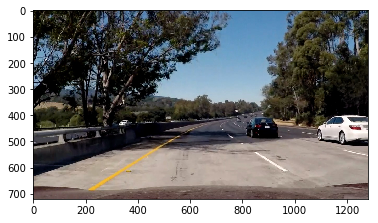

Output Image


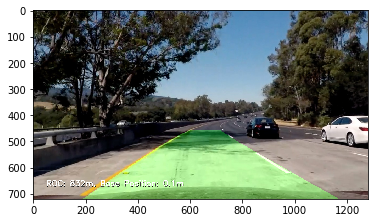

file name: straight_lines2.jpg
Original


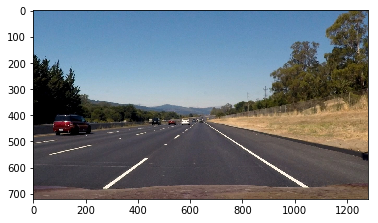

Output Image


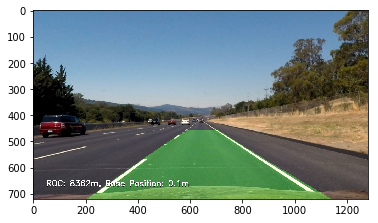

file name: test6.jpg
Original


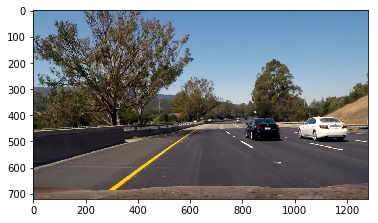

Output Image


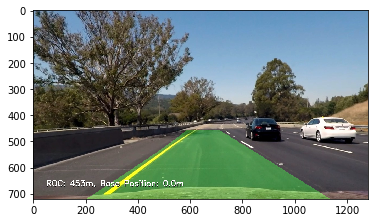

file name: test4.jpg
Original


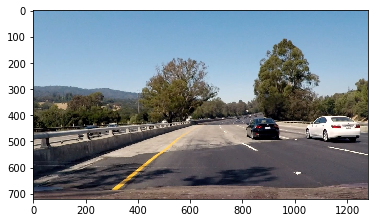

Output Image


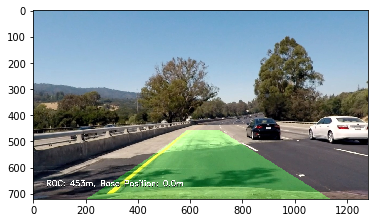

file name: straight_lines1.jpg
Original


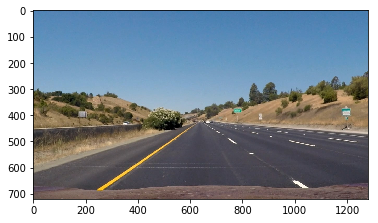

Output Image


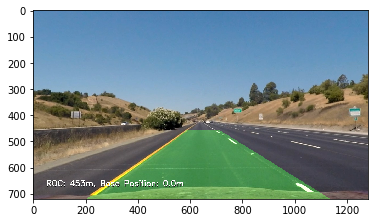

file name: test1.jpg
Original


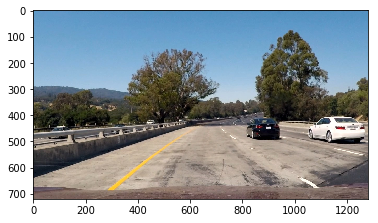

Output Image


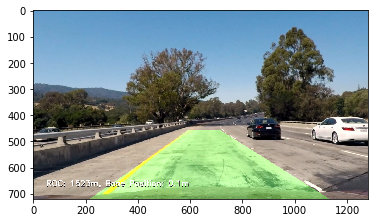

file name: test3.jpg
Original


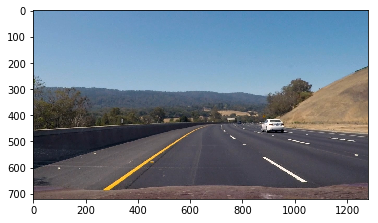

Output Image


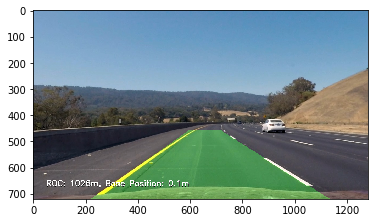

file name: test2.jpg
Original


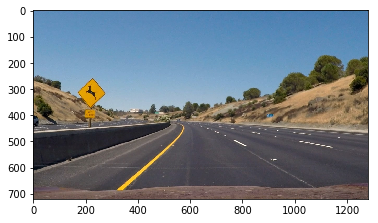

Output Image


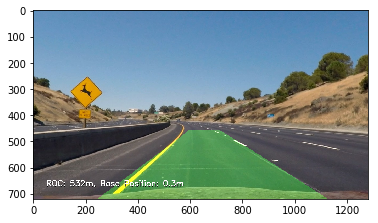

In [56]:
import os

test_folder = "test_images"
test_images = os.listdir(test_folder)
global left_line 
global right_line 
global bad_frame_count 
global max_bad_frame 
global max_good_fit 

left_line = Line()
right_line = Line()
bad_frame_count = 0
max_bad_frame = 8
max_good_fit = 5

for test_image in test_images:
    print('file name:',  test_image)    
    test_image_file = os.path.join(test_folder, test_image)    
    image = mpimg.imread(test_image_file)
    showColorImage(image, 'Original')
    out_image_2 = get_output(image)
    showColorImage(out_image_2, 'Output Image' )
   
 



  

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`project_video.mp4`



In [27]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [28]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    result = get_output(image)

    return result

Let's try the one with the solid white lane on the right first ...

In [29]:
output = 'project_solution_video_v3.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_solution_video_v3.mp4
[MoviePy] Writing video project_solution_video_v3.mp4


100%|█████████▉| 1260/1261 [02:01<00:00, 10.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_solution_video_v3.mp4 

CPU times: user 13min 41s, sys: 8.91 s, total: 13min 50s
Wall time: 2min 1s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [30]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

It is very intersting and challenging project for me since I am new to this field. By doing the project, I had a better understanding on how Canny, Hough works. And from forum, I was able to figure solutions for issues that I met in my project, like how to install OpenCV, how to separate left line and right line, how to remove some noise. Here are some thoughts on make pipeline working better:
1) The threshold of Canny and Hough can be better tuned, but it is very time cosumming. 
2) The law line function can definitely be improved to connect segment better. I don't have very good understanding on fitline function. There may be a better way to fit line better
3) On right curve image, my pipeline doesn't work very well on right line, wich stick out on the top. But I don't know how to make that better at this point.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))